<a href="https://colab.research.google.com/github/Shivanshu8211/2022---2023/blob/main/TiHAN_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cv2
import torch
# ! pip install timm
# ! pip install mediapipe
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

# Load Mediapipe pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

# Load MiDaS model
midas = torch.hub.load('intel-isl/MiDaS', 'DPT_Hybrid')

# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Function to predict depth of an image
def predict_depth(image_path):
    # Read image
    img = cv2.imread(image_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    return prediction.cpu().numpy()

# Example usage
image_path = "/content/Traffic_Light_img.jpg"
depth_map = predict_depth(image_path)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


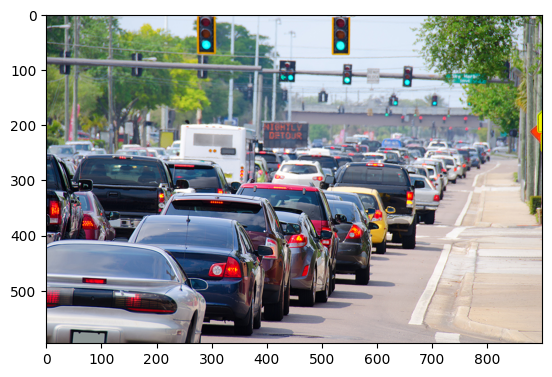

In [9]:
img = plt.imread(image_path)
plt.imshow(img)

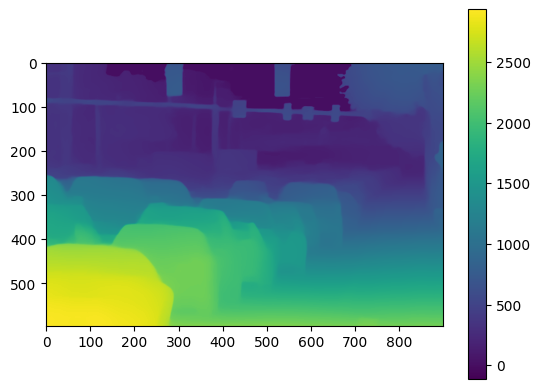

In [10]:
import matplotlib.pyplot as plt
plt.imshow(depth_map, cmap='viridis')
plt.colorbar()
plt.show()

In [11]:
depth_map=np.multiply(np.ones(depth_map.shape),np.amax(depth_map))-depth_map

In [12]:
def add_fog(image, depth_map, fog_density=0.6, fog_color=(255, 255, 255)):
    # Define maximum depth value for fog effect
    max_depth = depth_map.max()

    # Normalize depth map
    normalized_depth = depth_map / max_depth

    # Create fog overlay
    fog_overlay = np.zeros_like(image)
    fog_overlay[:, :, :] = fog_color
    fog_overlay = fog_density * fog_overlay.astype(np.float32)

    # Apply fog based on depth map
    foggy_image = image * (1 - normalized_depth[..., None]) + fog_overlay * normalized_depth[..., None]

    # Convert to uint8
    foggy_image = np.clip(foggy_image, 0, 255).astype(np.uint8)

    return foggy_image

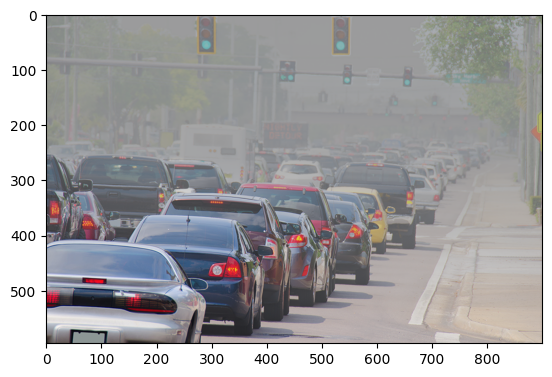

In [13]:
foggy_image = add_fog(img, depth_map)
plt.imshow(foggy_image)


In [14]:
import random
import cv2
import numpy as np
import random

def add_snow(image, depth_map, snow_density=0.02, snow_color=(255, 255, 255), snowflake_size=(1, 2)):
    h, w = image.shape[:2]
    snow_image = np.zeros_like(image)

    # Calculate snowflake count based on density
    num_snowflakes = int(h * w * snow_density)

    # Normalize depth map
    normalized_depth = depth_map / depth_map.max()

    for _ in range(num_snowflakes):
        x = random.randint(0, w - 1)
        y = random.randint(0, h - 1)

        # Apply snowflake if depth value is below a threshold
        depth_prob = normalized_depth[y, x] ** 2
        if random.random() < depth_prob:  # Adjust threshold as needed
            size = random.randint(*snowflake_size)
            cv2.circle(snow_image, (x, y), size, snow_color, -1)

    # Apply motion blur to simulate falling snow
    kernel_size = random.randint(2, 3)
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)
    snow_image = cv2.filter2D(snow_image, -1, kernel)

    # Combine snow overlay with original image
    snowy_image = cv2.addWeighted(image, 1, snow_image, 0.6, 0)

    return snowy_image

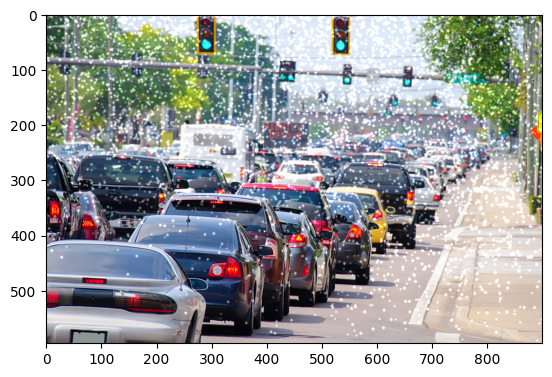

In [15]:
snowy_image = add_snow(img, depth_map)
plt.imshow(snowy_image)

In [37]:
def add_rain(image, rain_density=0.002, rain_length=(8, 18), rain_color=(136, 216, 210 )):
    h, w = image.shape[:2]
    rain_image = np.zeros_like(image)

    # Calculate raindrop count based on density
    num_raindrops = int(h * w * rain_density)

    for _ in range(num_raindrops):
        x = random.randint(0, w - 1)
        y = random.randint(0, h - 1)
        length = random.randint(*rain_length)
        thickness = random.randint(1, 2)
        cv2.line(rain_image, (x, y), (x, y + length), rain_color, thickness)

    # Combine rain overlay with original image
    rainy_image = cv2.addWeighted(image, 1, rain_image, 0.8, 0)

    return rainy_image
def make_image_dull(image):
    dull_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    dull_image[:, :, 1] = dull_image[:, :, 1] * 0.7  # Reduce saturation
    dull_image[:, :, 2] = dull_image[:, :, 2] * 0.7  # Reduce brightness
    dull_image = cv2.cvtColor(dull_image, cv2.COLOR_HSV2BGR)
    return dull_image

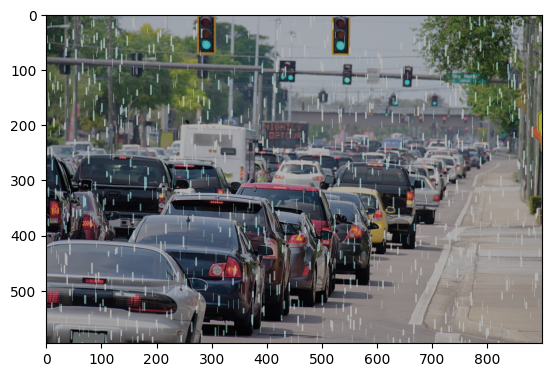

In [38]:
rainy_image = add_rain(img)
dull_rainy_image = make_image_dull(rainy_image)
plt.imshow(dull_rainy_image)